In [1]:
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
import requests
import zipfile
import plotly.graph_objects as go
import plotly.express as px
import ast
from plotly.subplots import make_subplots

%load_ext autoreload
%autoreload

In [2]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# data = physical signal

In [4]:
sampling_rate=100
path='/'

Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [5]:
X = load_raw_data(Y, sampling_rate, path)

In [6]:
print(Y.shape, X.shape)

(21799, 27) (21799, 1000, 12)


In [7]:
agg_df = pd.read_csv('scp_statements.csv', index_col=0)


In [8]:
agg_df = agg_df[agg_df.diagnostic == 1]

In [9]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [10]:
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [11]:
Y.diagnostic_superclass.to_csv('diagnostic_superclass', index=None)

In [12]:
test_fold = 10

X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass

X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [13]:
print('shape of x_train:',X_train.shape)
print('shape of x_test:',X_test.shape)
print('shape of Y_train:',y_train.shape)
print('shape of Y_train:',y_test.shape)

shape of x_train: (19601, 1000, 12)
shape of x_test: (2198, 1000, 12)
shape of Y_train: (19601,)
shape of Y_train: (2198,)


In [14]:
n_reports_per_patient = Y.groupby('patient_id').apply(lambda x: x.shape[0])
fig = px.histogram(n_reports_per_patient)
fig.update_layout(title = 'Histogram of number of ecg recordings per patient')

In [15]:
Y.device.value_counts(dropna = False)

CS100    3    6140
CS-12         4048
AT-6 C 5.5    3950
CS-12   E     2878
AT-6     6    2273
AT-60    3     966
AT-6 C 5.8     824
AT-6 C         514
AT-6 C 5.0      80
AT-6 C 5.3      67
AT-6 C 5.6      59
Name: device, dtype: int64

In [16]:
agg_df.diagnostic.value_counts()

1.0    44
Name: diagnostic, dtype: int64

In [17]:
Y.diagnostic_superclass.value_counts()

[NORM]                 9069
[MI]                   2532
[STTC]                 2400
[CD]                   1708
[CD, MI]               1297
[HYP, STTC]             781
[STTC, MI]              599
[HYP]                   535
[CD, STTC]              471
[]                      411
[NORM, CD]              407
[HYP, STTC, MI]         361
[CD, HYP]               238
[CD, STTC, MI]          223
[HYP, MI]               183
[HYP, STTC, CD]         113
[HYP, STTC, CD, MI]     102
[CD, STTC, HYP]          98
[CD, MI, HYP]            98
[HYP, CD]                62
[CD, STTC, MI, HYP]      54
[NORM, STTC]             28
[HYP, CD, MI]            19
[NORM, STTC, CD]          5
[NORM, CD, HYP]           2
[NORM, HYP]               2
[NORM, CD, MI, HYP]       1
Name: diagnostic_superclass, dtype: int64

In [18]:
Y.columns

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'diagnostic_superclass'],
      dtype='object')

In [19]:
px.histogram(Y, x = 'recording_date', histnorm='probability density', barmode = 'overlay', opacity = .3)

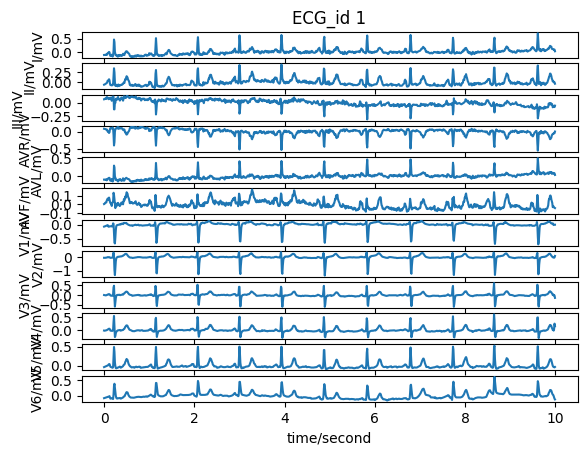

None

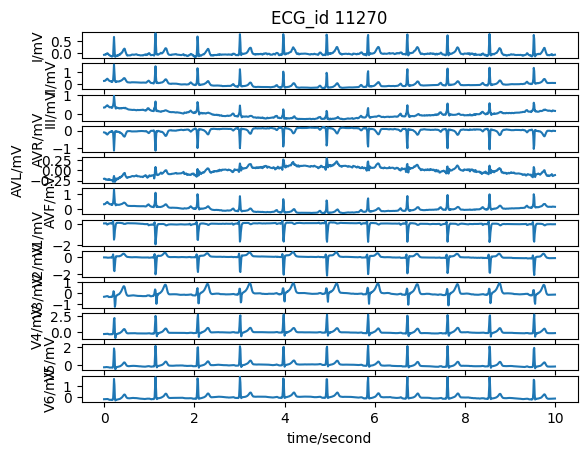

None

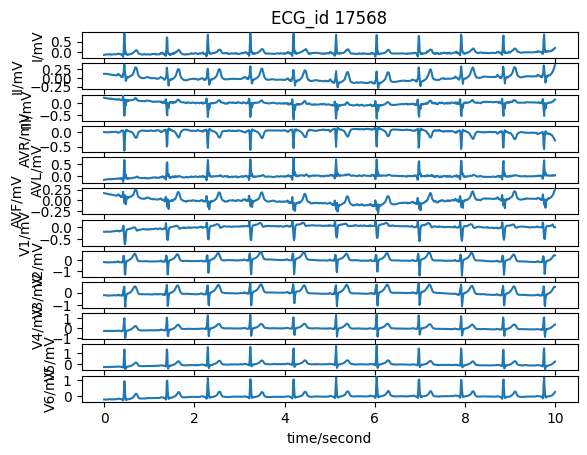

None

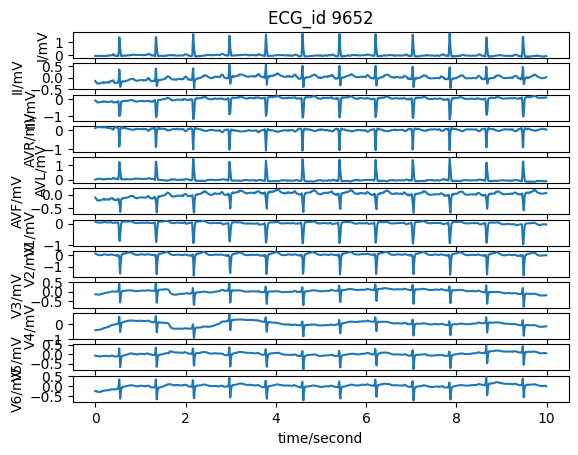

None

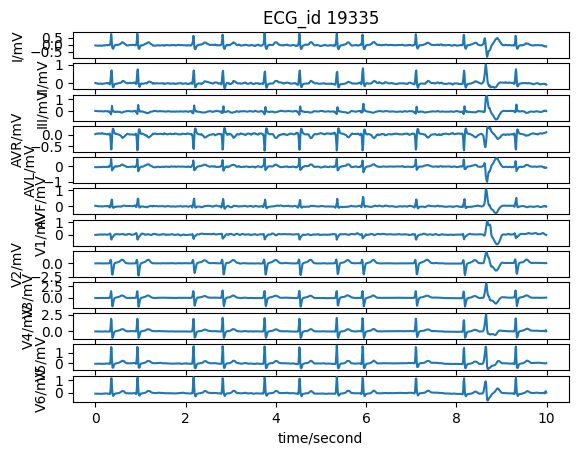

None

In [20]:
idxs = [0,10001, 15678, 8543, 17263]

for idx in idxs:
  ecg_id = y_train.index[idx]
  path = Y.filename_lr.iloc[idx]
  record = wfdb.rdrecord(path)
  display(wfdb.plot_wfdb(record=record, title=f'ECG_id {ecg_id}'))

In [21]:
path = Y.filename_lr.iloc[0]
record = wfdb.rdsamp(path)
# display(wfdb.plot_wfdb(record=record))
channels = record[1]['sig_name']

In [22]:
channels

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [23]:
idxs = [123, 8736, 10078, 15987, 4586, 2987, 14274, 12529]
for i in idxs:
    scp_code = Y.scp_codes.iloc[i]

In [24]:
def structured_interactive_signal_plot2(idxs: np.array, X: np.array, Y: pd.DataFrame, sampling_rate: int, channels = np.arange(12, dtype = np.int32)) -> None:

  channel_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  colors = px.colors.qualitative.Dark24
  for s_idx in idxs:
    # X_subject = X[s_idx, :, :]
    # scp_code = Y.scp_codes.iloc[s_idx]
    # ecg_id = Y.index[s_idx]

    # fig = go.Figure()
    # for n_idx, idx in enumerate(channels):
    #   fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,n_idx] + 2. * (len(channels) - n_idx), name = channel_names[n_idx], marker_color = colors[n_idx]))
    #   fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]) + 2. * (len(channels) - n_idx), marker_color = 'black', line = dict(width = 1.),  showlegend = False))
    # fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code}', yaxis = dict(showticklabels=False))
    # fig.show()
      scp_code = Y.scp_codes.iloc[s_idx]
     

idxs = [123, 8736, 10078, 15987, 4586, 2987, 14274, 12529]

structured_interactive_signal_plot2(idxs, X_train, y_train, sampling_rate, channels = np.arange(12, dtype = np.int32))
     


AttributeError: 'Series' object has no attribute 'scp_codes'

In [ ]:
colors = px.colors.qualitative.Dark24
idxs = [123, 8736, 10078, 15987, 4586, 2987, 14274, 12529]

for s_idx in [idxs]:
    X_subject = X[s_idx, :, :]
    scp_code = Y.scp_codes.apply.iloc[s_idx]
    ecg_id = Y.index[s_idx]

    fig = go.Figure()
    for n_idx, idx in enumerate(channels):
        fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,n_idx] + 2. * (len(channels) - n_idx), name = channels[n_idx], marker_color = colors[n_idx]))
        fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]) + 2. * (len(channels) - n_idx), marker_color = 'black', line = dict(width = 1.),  showlegend = False))
    fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code}', yaxis = dict(showticklabels=False))
    fig.show()

In [ ]:
display(y_train.iloc[12][['scp_codes','baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'r_peaks', 'diagnostic_superclass' ]])

In [ ]:
for clm in ['static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']:
    mask = ~y_train[clm].isna().reset_index(drop=True)
    idxs = mask[mask].index
    idxs = np.random.choice(idxs, size = (2))

    print(f'\n{clm}:')
    display(y_train.iloc[idxs,:][['scp_codes','baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
        'extra_beats', 'pacemaker', 'r_peaks', 'diagnostic_superclass' ]])
    structured_interactive_signal_plot2(idxs, X_train, y_train, sampling_rate, channels = np.arange(12, dtype = np.int32))
  

FEATURE EXTRACTION

In [ ]:
from ecgdetectors import Detectors
detectors = Detectors(sampling_rate)

# Padding to help detect initial peaks:
r_peaks = np.array(detectors.hamilton_detector(np.hstack((np.zeros(10),X_train[0,:,1])))) - 10
r_peaks_wvt = np.array(detectors.swt_detector(np.hstack((np.zeros(20),X_train[0,:,1])))) - 20

print(r_peaks)
print(r_peaks_wvt)


[ 28 120 213 306 399 490 588 685 779 867 963]
[ 19  56 112 199 297 390 484 579 675 770 861 957]


In [ ]:
import neurokit2 as nk
u, rpeaks = nk.ecg_peaks(X_train[0,:,1], sampling_rate=sampling_rate)
print(rpeaks)

{'ECG_R_Peaks': array([115, 208, 300, 393, 487, 583, 679, 773, 864, 961]), 'sampling_rate': 100}


In [ ]:
import neurokit2 as nk
from ecgdetectors import Detectors
import sys

def advanced_interactive_signal_plot(idxs: np.array, X: np.array, Y: pd.DataFrame, sampling_rate: int, channels = np.arange(12, dtype = np.int32), rpeak_style = 'nk') -> None:
  channel_names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

  colors = px.colors.qualitative.Dark24
  for s_idx in idxs: # subject_index:
    X_subject = X[s_idx, :, :]
    scp_code = Y.scp_codes.iloc[s_idx]
    ecg_id = Y.index[s_idx]

    heart_rates = {}

    fig = go.Figure()
    for n_idx, idx in enumerate(channels):
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = X_subject[:,idx] + 2. * (len(channels) - n_idx), name = channel_names[idx], marker_color = colors[idx]))
      fig.add_trace(go.Scatter(x = np.arange(X_subject.shape[0]) / sampling_rate, y = np.zeros(X_subject.shape[0]) + 2. * (len(channels) - n_idx), marker_color = 'black', line = dict(width = 1.),  showlegend = False))
      
      # Estimate R-peaks:
      if rpeak_style == 'nk':
        _, rpeaks = nk.ecg_peaks(X_subject[:,idx], sampling_rate=sampling_rate)
        rpeaks = rpeaks['ECG_R_Peaks'].astype('float') / sampling_rate
      elif rpeak_style == 'hamilton':
        detectors = Detectors(sampling_rate)
        rpeaks = (np.array(detectors.hamilton_detector(X_subject[:,idx]))).astype('float')  / sampling_rate # np.hstack((np.zeros(10),
      elif rpeak_style == 'wvt':
        detectors = Detectors(sampling_rate)
        rpeaks = np.array(detectors.swt_detector(X_subject[:,idx])).astype('float') / sampling_rate
      else:
        sys.exit('Incorrect rpeak_style. Options: "nk", "hamilton", "wvt".')

      heart_rates[channel_names[idx]] = (rpeaks.shape[0] - 1) * sampling_rate / (rpeaks[-1] - rpeaks[0]) 

      for r in rpeaks:
        fig.add_trace(go.Scatter(x = r * np.ones(20), y = np.linspace(-1, 1, num = 20) + 2. * (len(channels) - n_idx), line = dict(color = 'grey'), showlegend = False))
    
    fig.update_layout(title = f'ECG id: {ecg_id}, scp: {scp_code} - R-peaks: grey', yaxis = dict(showticklabels=False))
    fig.show()
    display(pd.Series(heart_rates, name = 'heart_rates'))

advanced_interactive_signal_plot([0,1], X_train, y_train, sampling_rate, rpeak_style = 'nk')
     
